<a href="https://colab.research.google.com/github/Nighty13/Behavioral-Cloning--SelfDrivingCar/blob/master/BehaviorCloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [125]:
!git clone https://github.com/Nighty13/Track

fatal: destination path 'Track' already exists and is not an empty directory.


In [126]:
!ls Track

drive.py  driving_log.csv  IMG	model.h5  model_old.h5	README.md


In [127]:
!pip3 install imgaug

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D,MaxPooling2D,Dropout,Flatten,Dense
import cv2
from imgaug import augmenters as iaa
import pandas as pd
import ntpath
import random
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [129]:
datadir='Track'
columns=['center','left','right','steering','throttle','reverse','speed']
data=pd.read_csv(os.path.join(datadir,'driving_log.csv'),names=columns)
pd.set_option('display.max_colwidth',-1)
data.head()



center  \
0  C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\center_2018_10_18_02_27_48_180.jpg   
1  C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\center_2018_10_18_02_27_48_246.jpg   
2  C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\center_2018_10_18_02_27_48_314.jpg   
3  C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\center_2018_10_18_02_27_48_383.jpg   
4  C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\center_2018_10_18_02_27_48_451.jpg   

                                                                       left  \
0  C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\left_2018_10_18_02_27_48_180.jpg   
1  C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\left_2018_10_18_02_27_48_246.jpg   
2  C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\left_2018_10_18_02_27_48_314.jpg   
3  C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\left_2018_10_18_02_27_48_383.jpg   
4  C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\left_2018_10_18_02_27_48_451.jpg   

                                                                       right  \
0  C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\right_2018_10_18_02_27_48_180.jpg   
1  C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\right_2018_10_18_02_27_48_246.jpg   
2  C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\right_2018_10_18_02_27_48_314.jpg   
3  C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\right_2018_10_18_02_27_48_383.jpg   
4  C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\right_2018_10_18_02_27_48_451.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.0       0.0      7.862732  
1  0.0       0.0       0.0      7.815299  
2  0.0       0.0       0.0      7.768152  
3  0.0       0.0       0.0      7.705731  
4  0.0       0.0       0.0      7.659244

In [130]:
def path_leaf(path):
  head,tail=ntpath.split(path)
  return tail
data['center']=data['center'].apply(path_leaf)
data['left']=data['left'].apply(path_leaf)
data['right']=data['right'].apply(path_leaf)
data.head()


center                              left  \
0  center_2018_10_18_02_27_48_180.jpg  left_2018_10_18_02_27_48_180.jpg   
1  center_2018_10_18_02_27_48_246.jpg  left_2018_10_18_02_27_48_246.jpg   
2  center_2018_10_18_02_27_48_314.jpg  left_2018_10_18_02_27_48_314.jpg   
3  center_2018_10_18_02_27_48_383.jpg  left_2018_10_18_02_27_48_383.jpg   
4  center_2018_10_18_02_27_48_451.jpg  left_2018_10_18_02_27_48_451.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2018_10_18_02_27_48_180.jpg  0.0       0.0       0.0      7.862732  
1  right_2018_10_18_02_27_48_246.jpg  0.0       0.0       0.0      7.815299  
2  right_2018_10_18_02_27_48_314.jpg  0.0       0.0       0.0      7.768152  
3  right_2018_10_18_02_27_48_383.jpg  0.0       0.0       0.0      7.705731  
4  right_2018_10_18_02_27_48_451.jpg  0.0       0.0       0.0      7.659244

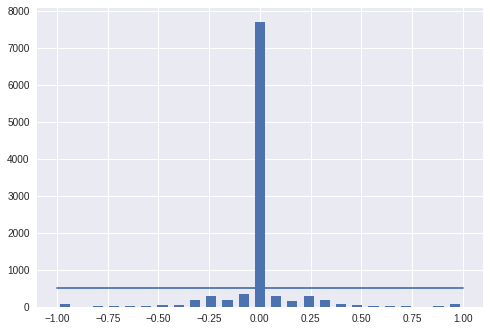

In [131]:
num_bins=25
samples_per_bin=500
hist,bins=np.histogram(data['steering'],num_bins)
center=(bins[:-1]+bins[1:])*0.5
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

total data: 10139
removed: 7190
remaining: 2949


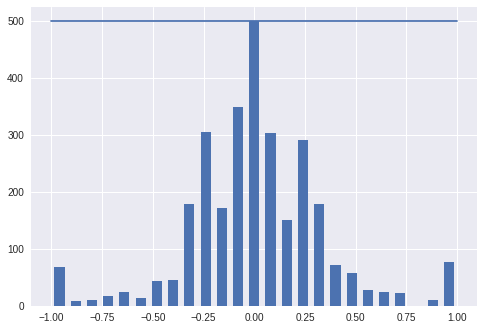

In [132]:
print('total data:',len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [133]:
print(data.iloc[1])
def load_img_steering(datadir,df):
  image_path=[]
  steering=[]
  
  for i in range(len(data)):
    indexed_data=data.iloc[i]
    center,left,right=indexed_data[0],indexed_data[1],indexed_data[3]
    image_path.append(os.path.join(datadir,center.strip()))
    steering.append(float(indexed_data[3]))
    
  image_paths=np.asarray(image_path)
  steerings=np.asarray(steering)
  return image_paths,steerings
    
image_paths,steerings=load_img_steering(datadir+'/IMG',data)

center      center_2018_10_18_02_27_49_133.jpg
left        left_2018_10_18_02_27_49_133.jpg  
right       right_2018_10_18_02_27_49_133.jpg 
steering   -0.3                               
throttle    0.79992                           
reverse     0                                 
speed       8.45756                           
Name: 14, dtype: object


In [134]:
X_train,X_valid,y_train,y_valid=train_test_split(image_paths,steerings,test_size=0.2,random_state=5)
print('Training Samples : {}\nValid Samples : {}'.format(len(X_train),len(X_valid)))

Training Samples : 2359
Valid Samples : 590


Text(0.5,1,'Validation set')

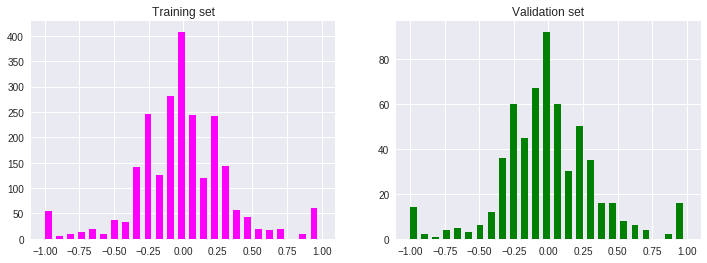

In [135]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='magenta')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='green')
axes[1].set_title('Validation set')

In [0]:
def zoom(image):
  zoom=iaa.Affine(scale=(1,1.3))
  image=zoom.augment_image(image)
  return image

Text(0.5,1,'Zoomed Image')

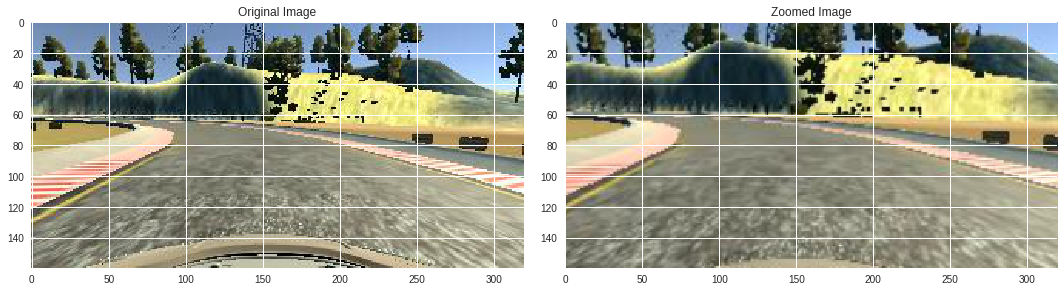

In [137]:
image=image_paths[random.randint(0,1000)]
original_image=mpimg.imread(image)
zoomed_image=zoom(original_image)

fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')


In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent={"x":(-0.1,0.1),"y":(-0.1,0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5,1,'Panned image')

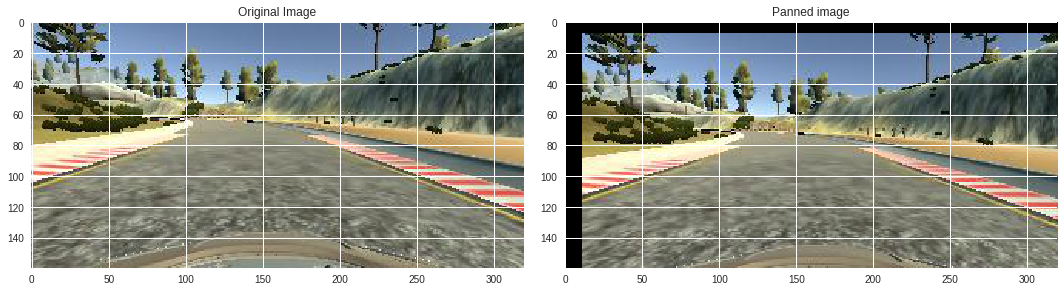

In [139]:
image=image_paths[random.randint(0,1000)]
original_image=mpimg.imread(image)
panned_image=pan(original_image)

fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(panned_image)
axs[1].set_title('Panned image')

In [0]:
def img_random_brightness(image):
  brightness=iaa.Multiply((0.2,1.2))
  image=brightness.augment_image(image)
  return image

Text(0.5,1,'brightness_altered_image image')

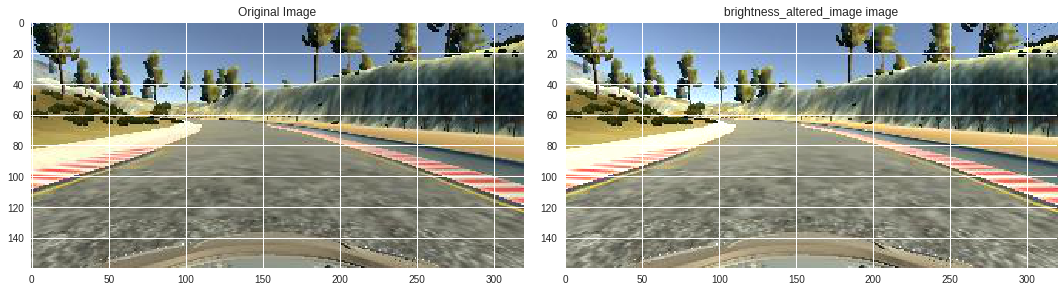

In [141]:
image=image_paths[random.randint(0,1000)]
original_image=mpimg.imread(image)
brightness_altered_image=img_random_brightness(original_image)

fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(brightness_altered_image)
axs[1].set_title('brightness_altered_image image')

In [0]:
def img_random_flip(image,steering_angle):
  image = cv2.flip(image,1)
  steering_angle=-steering_angle
  return image,steering_angle

Text(0.5,1,'Flipped Image - Steering Angle:0.05')

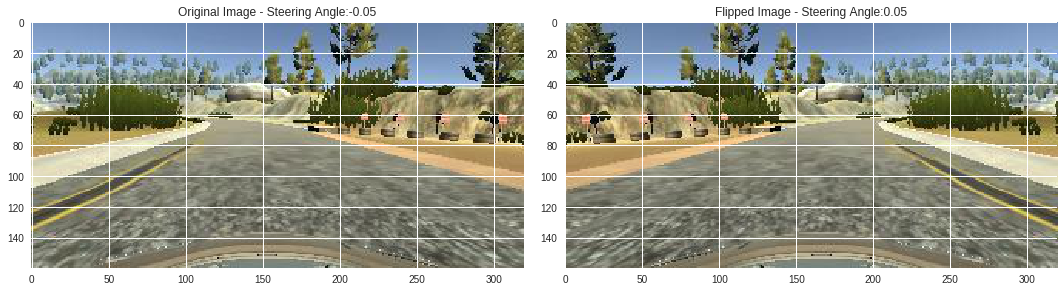

In [143]:
random_index=random.randint(0,1000)
image=image_paths[random_index]
steering_angle=steerings[random_index]
original_image=mpimg.imread(image)
flipped_image,flipped_steering_angle=img_random_flip(original_image,steering_angle)
fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' +str(steering_angle))
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' +str(flipped_steering_angle))

In [0]:
def random_augment(image,steering_angle):
  image=mpimg.imread(image)
  if np.random.rand()<0.5:
    image=pan(image)
  if np.random.rand()<0.5:
    image=zoom(image)
  if np.random.rand()<0.5:
    image=img_random_brightness(image)
  if np.random.rand()<0.5:
    image,steering_angle=img_random_flip(image,steering_angle)
  return image,steering_angle

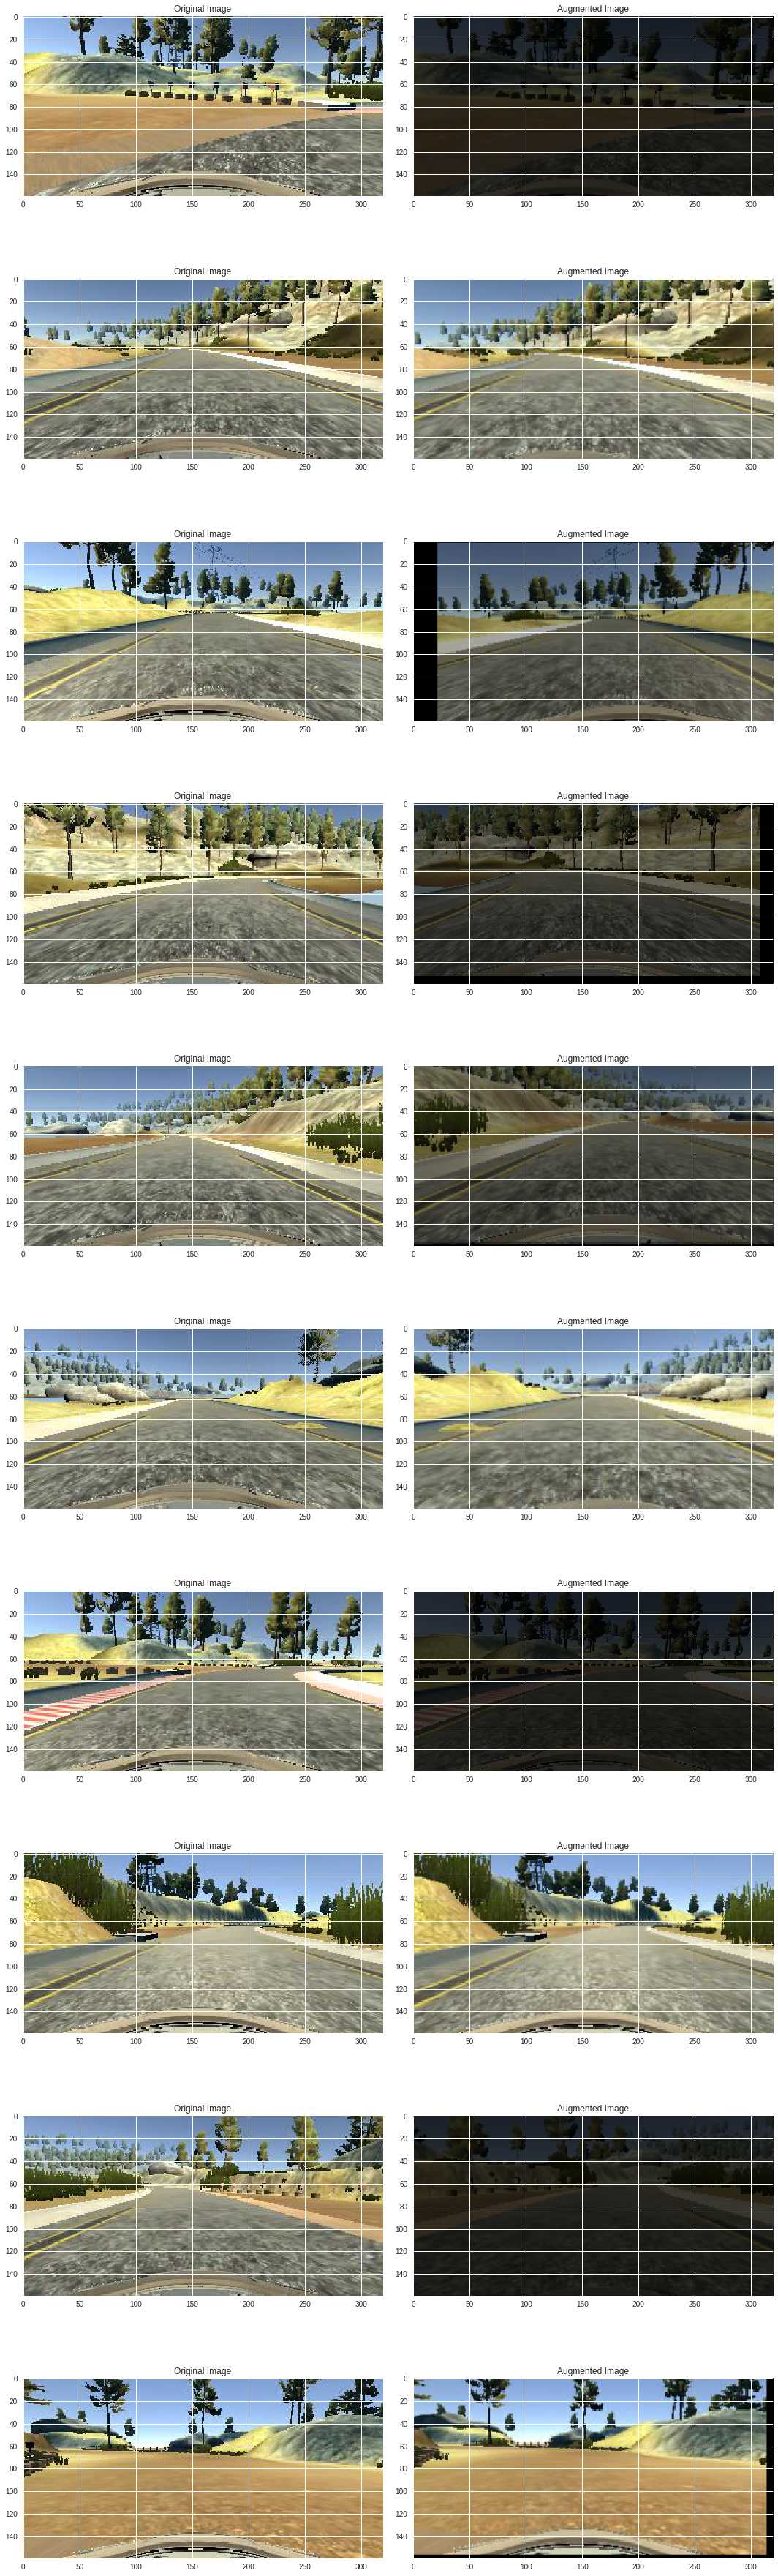

In [145]:
ncol=2
nrow=10
fig,axs=plt.subplots(nrow,ncol,figsize=(15,50))
fig.tight_layout()
for i in range(10):
  randnum=random.randint(0,len(image_paths)-1)
  random_image=image_paths[randnum]
  random_steering=steerings[randnum]
  original_image=mpimg.imread(random_image)
  augmented_image,steering=random_augment(random_image,random_steering)
  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original Image')
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('Augmented Image')

In [0]:
def img_preprocess(img):
  img=mpimg.imread(img)
  img=img[60:140,:,:]
  img=cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  img=cv2.GaussianBlur(img,(3,3),0)
  img=cv2.resize(img,(200,66))
  img=img/255
  return img

Text(0.5,1,'Preprocssed Image')

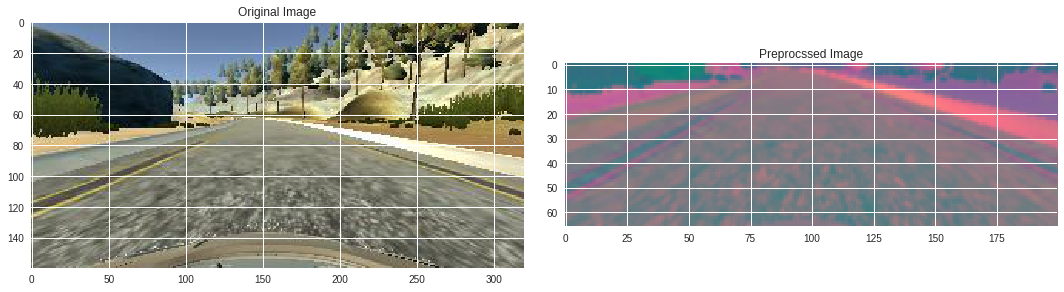

In [147]:
image = image_paths[100]
original_image=mpimg.imread(image)
preprocessed_image=img_preprocess(image)

fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocssed Image')


In [0]:
X_train=np.array(list(map(img_preprocess,X_train)))
X_valid=np.array(list(map(img_preprocess,X_valid)))

(2359, 66, 200, 3)


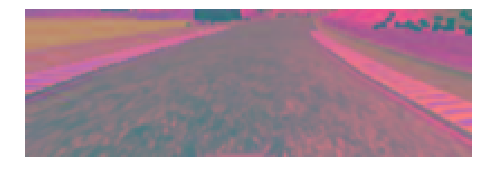

In [149]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

In [0]:
def nvidia_model():
  model=Sequential()
  model.add(Convolution2D(24,5,5,subsample=(2,2),input_shape=(66,200,3),activation='elu'))
  model.add(Convolution2D(36,5,5,subsample=(2,2),activation='elu'))
  model.add(Convolution2D(48,5,5,subsample=(2,2),activation='elu'))
  model.add(Convolution2D(64,3,3,activation='elu'))
  model.add(Convolution2D(64,3,3,activation='elu'))
  #model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(100,activation='elu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(50,activation='elu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(10,activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  optimizer=Adam(lr=1e-3)
  model.compile(loss='mse',optimizer=optimizer)
  return model
  

In [151]:
model=nvidia_model()
print (model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 100)               115300    
__________

In [152]:
history=model.fit(X_train,y_train,epochs=30,validation_data=(X_valid,y_valid),batch_size=100,verbose=1,shuffle=1)

Train on 2359 samples, validate on 590 samples
Epoch 1/30
2359/2359 [==============================] - 3s 1ms/step - loss: 0.3597 - val_loss: 0.1104
Epoch 2/30
2359/2359 [==============================] - 2s 672us/step - loss: 0.1120 - val_loss: 0.1008
Epoch 3/30
2359/2359 [==============================] - 2s 670us/step - loss: 0.0953 - val_loss: 0.0882
Epoch 4/30
2359/2359 [==============================] - 2s 668us/step - loss: 0.0835 - val_loss: 0.0818
Epoch 5/30
2359/2359 [==============================] - 2s 663us/step - loss: 0.0825 - val_loss: 0.0779
Epoch 6/30
2359/2359 [==============================] - 2s 666us/step - loss: 0.0716 - val_loss: 0.0658
Epoch 7/30
2359/2359 [==============================] - 2s 673us/step - loss: 0.0678 - val_loss: 0.0699
Epoch 8/30
2359/2359 [==============================] - 2s 671us/step - loss: 0.0651 - val_loss: 0.0639
Epoch 9/30
2359/2359 [==============================] - 2s 672us/step - loss: 0.0619 - val_loss: 0.0611
Epoch 10/30
2359/23

Text(0.5,0,'Epoch')

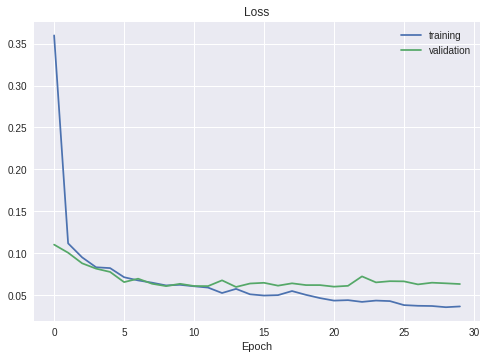

In [153]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
model.save('model.h5')


In [0]:
from google.colab import files
files.download('model.h5')